# Mesa-Tutorial

This tutorial is based on https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html

* To install mesa, please follow the instruction sheet we provided you and not the pip install method
* If you are not confident with Python, there is plenty of support online. We also prepared a Python refresher for another course that you can use to catch up: https://gitlab.tudelft.nl/inikolic/tb231c_python_selftest

## 1. Setting up the model

In [42]:
import mesa
import matplotlib.pyplot as plt

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

## 2. Adding the scheduler and step method

Time in most agent-based models moves in steps, sometimes also called ticks. At each step of the model, one or more of the agents – usually all of them – are activated and take their own step, changing internally and/or interacting with one another or the environment.

In [43]:
import mesa

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent " + str(self.unique_id) + ".")


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

In [22]:
empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agentss 2.
Hi, I am agentss 7.
Hi, I am agentss 8.
Hi, I am agentss 3.
Hi, I am agentss 1.
Hi, I am agentss 9.
Hi, I am agentss 6.
Hi, I am agentss 5.
Hi, I am agentss 4.
Hi, I am agentss 0.


## 3 Change Agent behaviour
Try modifying the code above to have every agent print out its wealth when it is activated. Run a few steps of the model to see how the agent activation order is shuffled each step.

In [34]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

### 3.1 Running your first model

In [35]:
model = MoneyModel(10)

for i in range(10):
    model.step()

In [36]:
# For a jupyter notebook add the following line:
%matplotlib inline

(array([4., 0., 0., 3., 0., 0., 2., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

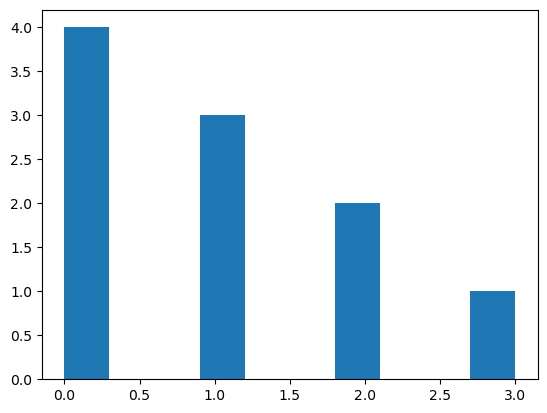

In [37]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

### 3.2 Model behaviour

To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

(array([424., 308., 166.,  64.,  24.,  14.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 6 artists>)

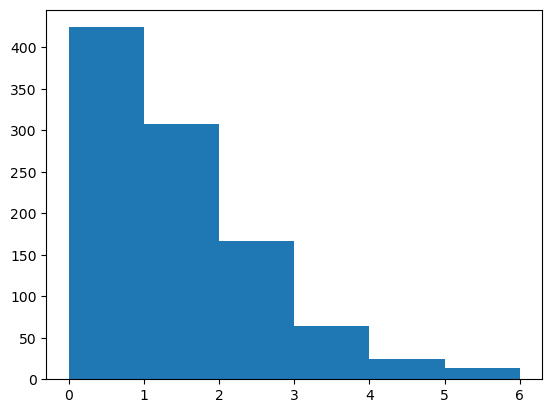

In [41]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

## Adding space

Mesa has two main types of grids: SingleGrid and MultiGrid*. SingleGrid enforces at most one agent per cell; MultiGrid allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use MultiGrid.

In [9]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

## Move Agent to a neighbourhood cell

In [10]:
class MoneyAgent(mesa.Agent):
   #...
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

Next, we need to get all the other agents present in a cell, and give one of them some money. We can get the contents of one or more cells using the grid’s get_cell_list_contents method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

In [11]:
class MoneyAgent(mesa.Agent):
    #...
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

And with those two methods, the agent’s step method becomes:

In [12]:
class MoneyAgent(mesa.Agent):
    # ...
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

Now, putting that all together should look like this:

In [44]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

Let’s create a model with 50 agents on a 10x10 grid, and run it for 20 steps.

In [14]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

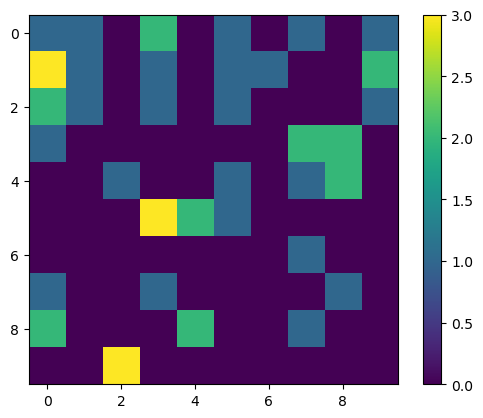

In [15]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

## Collecting Data

Let’s add a DataCollector to the model with mesa.DataCollector, and collect two variables. At the agent level, we want to collect every agent’s wealth at every step. At the model level, let’s measure the model’s Gini Coefficient, a measure of wealth inequality.

In [16]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


In [17]:

class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [18]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot: >

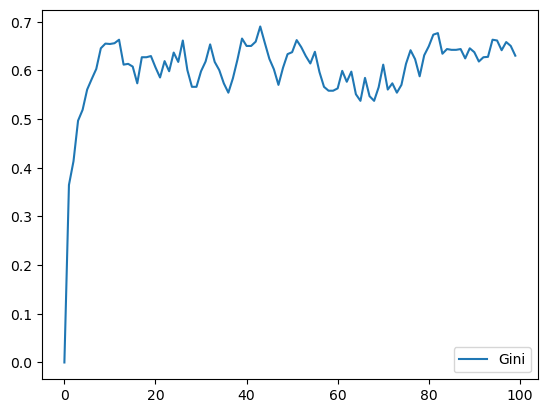

In [19]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [20]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Wealth
Step AgentID        
99   45            1
     46            4
     47            3
     48            0
     49            0

## Batch Run??

Like we mentioned above, you usually won’t run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model’s outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a batch_run function which automates it for you.